# Introduction

Le but du projet est de mettre en place un réseau de convolution (ou CNN) qui est capable d'associer à une image d'un paysage, le pays dans lequel celle ci à été prise. Pour simplifier la classification, on restreint l'étude à 5 pays.

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
list_of_countries = ["Australia", "France", "Japan", "Mexico", "United States"]

base_dir = "/content/drive/MyDrive/Projets/Projet_CNN_countries/"
dataset_dir = base_dir + "dataset_countries/"

In [ ]:
import os

for country in list_of_countries:
  list_files = os.listdir(dataset_dir + country) 
  number_files = len(list_files)
  print(country + ": " + str(number_files))

Australia: 1376
France: 2867
Japan: 3066
Mexico: 725
United States: 9566


Le code ci-dessous permet de créer une division train/ test à partir d'une BDD. Il n'est compilé qu'une fois en conséquence. 

In [ ]:
import os 
import shutil
import numpy as np

'''
for country in list_of_countries:
  train_dir = base_dir + "train/" + country
  test_dir = base_dir + "test/" + country
  files = os.listdir(train_dir)
  for f in files:
    if np.random.rand(1) < 0.2:
      shutil.move(train_dir + '/' + f, test_dir + '/' + f)
'''

'\nfor country in list_of_countries:\n  train_dir = base_dir + "train/" + country\n  test_dir = base_dir + "test/" + country\n  files = os.listdir(train_dir)\n  for f in files:\n    if np.random.rand(1) < 0.2:\n      shutil.move(train_dir + \'/\' + f, test_dir + \'/\' + f)\n'

In [ ]:
from keras.preprocessing.image import img_to_array
import cv2
import os
import numpy as np

'''
X_train, X_test, y_train, y_test = [], [], [], []

for country in list_of_countries:

  print(country)
  actual_dir = base_dir + 'train/' + country
  
  for f in os.listdir(actual_dir):
    image = cv2.imread(actual_dir + "/" + f)
    image = cv2.resize(image, (150, 300))
    X_train.append(img_to_array(image))
    y_train.append(country)
'''

'\nX_train, X_test, y_train, y_test = [], [], [], []\n\nfor country in list_of_countries:\n\n  print(country)\n  actual_dir = base_dir + \'train/\' + country\n  \n  for f in os.listdir(actual_dir):\n    image = cv2.imread(actual_dir + "/" + f)\n    image = cv2.resize(image, (150, 300))\n    X_train.append(img_to_array(image))\n    y_train.append(country)\n'

# Mise en place d'un premier modèle simple

L'utilisation d'un générateur d'image permet ici de travailler directement sur la base de données très simplement. On peut alors spécifier que 80% de la base de données sera utilisée pour entrainer le modèle, et les 20% restants seront utilisés pour vérifier si le modèle est bien efficace.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(dataset_dir,
                                              target_size=(150, 300), batch_size=64,
                                              class_mode='categorical', subset='training')

val_generator = datagen.flow_from_directory(dataset_dir,
                                            target_size=(150, 300), batch_size=64,
                                            class_mode='categorical', subset='validation')

Found 14081 images belonging to 5 classes.
Found 3519 images belonging to 5 classes.


Les images de la base de données sont initialement en couleurs, et de dimension 1536x662. Cependant, en les utilisant telles quelles pour le projet, le temps de compilation est alors beaucoup trop long. On choisit alors de diminuer la dimensions des images en 300x150, tout en gardant les couleurs. 

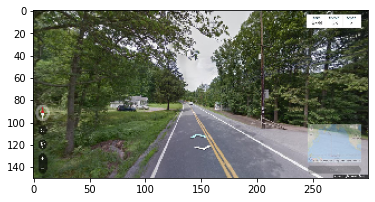

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_generator[0][0][0])

On met alors en place un simple réseaux de neurones utilisant des couches de convolutions et de pooling pour la partie d'instanciation, puis une couche flatten suivie de deux couches denses pour la partie classifieur.

La fonction d'activation de sortie est softmax car il y a plusieurs classes. 

In [ ]:
from keras import layers, models

model_base = models.Sequential()

# Instanciation
model_base.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 300, 3))) #Input_shape à modifier (RGB:3, NB:1)
model_base.add(layers.MaxPooling2D(2, 2))
model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D(2, 2))
model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Classifieur
model_base.add(layers.Flatten())
model_base.add(layers.Dense(32, activation='relu'))
model_base.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 149, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 147, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 71, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 154496)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4

On met en place plusieurs métriques qui sont la précision, le rappel, ainsi que le score f1. 

Le critère qui nous intéresse le plus ici est le Rappel, défini par le nombre de prédiction correctes pour une classe, sur le nombre de données de la classe en question (dans le cas de la multiclassification, on utilise la méthode one vs all). 

Le rappel s'interprète ici comme étant l'aptitude à détecter le bon pays, sans s'inquiéter des potentielles mauvaises classifications. 

In [3]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras import optimizers
from keras.models import load_model

model_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[recall_m, precision_m, f1_m])

In [ ]:
history = model_base.fit_generator(train_generator, validation_data=val_generator,
                                   steps_per_epoch=50, epochs=50, validation_steps=30)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 986s 19s/step - loss: 1.5399 - recall_m: 0.3519 - precision_m: 0.4726 - f1_m: 0.3760 - val_loss: 1.2339 - val_recall_m: 0.4703 - val_precision_m: 0.5673 - val_f1_m: 0.5139
Epoch 2/50
50/50 [==============================] - 670s 13s/step - loss: 1.2075 - recall_m: 0.3741 - precision_m: 0.6355 - f1_m: 0.4507 - val_loss: 1.1733 - val_recall_m: 0.4187 - val_precision_m: 0.6176 - val_f1_m: 0.4980
Epoch 3/50
50/50 [==============================] - 474s 10s/step - loss: 1.1628 - recall_m: 0.4238 - precision_m: 0.6517 - f1_m: 0.5095 - val_loss: 1.2066 - val_recall_m: 0.2776 - val_precision_m: 0.7181 - val_f1_m: 0.3985
Epoch 4/50
50/50 [==============================] - 368s 7s/step - loss: 1.1649 - recall_m: 0.3841 - precision_m: 0.6827 - f1_m: 0.4847 - val_loss: 1.1805 - val_recall_m: 0.2740 - val_precision_m: 0.7093 - val_f1_m: 0.3933
Epoch 5/50
50/50 [==============================] - 294s 6s/step - loss: 1.1419 - recall_m: 0.3764 - prec

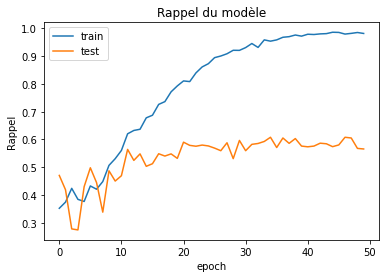

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Rappel du modèle')
plt.ylabel('Rappel')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

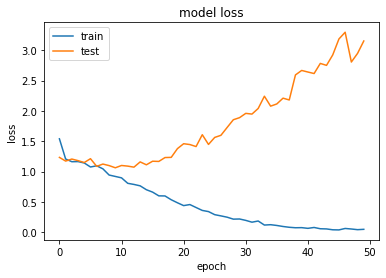

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

On constate un sur-apprentissage.

# Mise en place de l'augmentation des données

Afin de passer outre le sur-apprentissage, on choisit l'augmentation de données, consistant en la modification des données d'entrainement afin d'obtenir plus de données, ce qui augmente alors la performance du modèle.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                             width_shift_range=0.1, height_shift_range=0.1,
                             brightness_range=[0.7, 1.3],
                             rotation_range=10, zoom_range=0.2,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(dataset_dir,
                                              target_size=(150, 300), batch_size=32,
                                              class_mode='categorical', subset='training')

val_generator = datagen.flow_from_directory(dataset_dir,
                                            target_size=(150, 300), batch_size=32,
                                            class_mode='categorical', subset='validation')

Found 14081 images belonging to 5 classes.
Found 3519 images belonging to 5 classes.


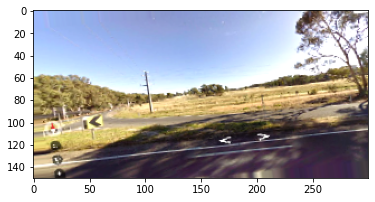

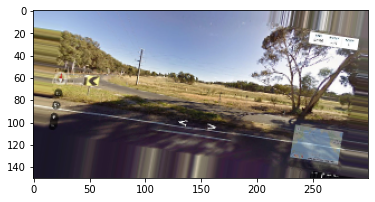

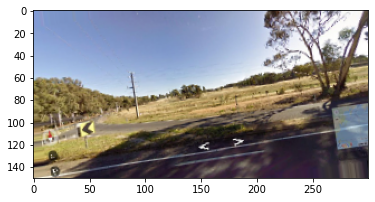

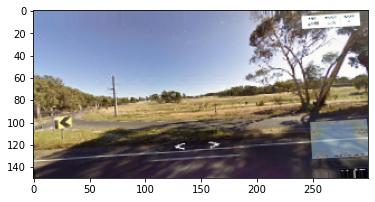

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

img = image.load_img(dataset_dir+"/Australia/canvas_1629257606.jpg", target_size=(150, 300))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

for batch, i in zip(datagen.flow(x, batch_size=1), range(4)):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
plt.show()

On ajoute uniquement une couche de dropout au modèle pour lutter plus efficacement contre le sur-ajustement. 

Note: Le dropout n'est pas vraiment utile à la suite d'une couche de convolution; dans ce cas on préferera la normalisation de batch (à travailler).

In [ ]:
from keras import layers, models

model_dataAug = models.Sequential()

# Instanciation
model_dataAug.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 300, 3))) #Input_shape à modifier (RGB:3, NB:1)
model_dataAug.add(layers.MaxPooling2D(2, 2))
model_dataAug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dataAug.add(layers.MaxPooling2D(2, 2))
model_dataAug.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Classifieur
model_dataAug.add(layers.Flatten())
model_dataAug.add(layers.Dropout(0.5))
model_dataAug.add(layers.Dense(32, activation='relu'))
model_dataAug.add(layers.Dense(5, activation='softmax'))

In [ ]:
from keras import optimizers

model_dataAug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[recall_m, precision_m, f1_m])

In [ ]:
history = model_dataAug.fit_generator(train_generator, validation_data=val_generator,
                                   steps_per_epoch=50, epochs=50, validation_steps=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
50/50 [==============================] - 1075s 22s/step - loss: 1.8370 - recall_m: 0.2062 - precision_m: 0.6988 - f1_m: 0.3086 - val_loss: 1.5385 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 908s 18s/step - loss: 1.7990 - recall_m: 0.2362 - precision_m: 0.6855 - f1_m: 0.3378 - val_loss: 2.0211 - val_recall_m: 0.0010 - val_precision_m: 0.0067 - val_f1_m: 0.0018
Epoch 3/50
50/50 [==============================] - 784s 16s/step - loss: 1.6106 - recall_m: 0.2469 - precision_m: 0.6743 - f1_m: 0.3508 - val_loss: 1.3002 - val_recall_m: 0.2833 - val_precision_m: 0.6250 - val_f1_m: 0.3869
Epoch 4/50
50/50 [==============================] - 690s 14s/step - loss: 1.4631 - recall_m: 0.2688 - precision_m: 0.6478 - f1_m: 0.3722 - val_loss: 1.5276 - val_recall_m: 0.0073 - val_precision_m: 0.0811 - val_f1_m: 0.0132
Epoch 5/50
50/50 [==============================] - 591s 12s/step - loss: 1.3686 - recall_m

In [ ]:
model_dataAug.save('model_dataAug.h5')

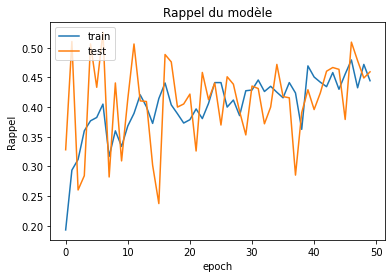

In [ ]:
# summarize history for accuracy
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Rappel du modèle')
plt.ylabel('Rappel')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

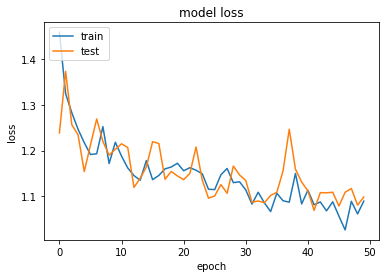

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Mise en place d'un réseau pré-entrainé dont on extrait les caractéristiques

## Réseau VGG16

In [ ]:
from keras import layers, models
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 300, 3))

# On gèle les poids des couches d'instanciation du modèle
conv_base.trainable = False

model_preTrained = models.Sequential()

# Instanciation
model_preTrained.add(conv_base)

# Classifieur
model_preTrained.add(layers.Flatten())
model_preTrained.add(layers.Dropout(0.5))
model_preTrained.add(layers.Dense(32, activation='relu'))
model_preTrained.add(layers.Dense(5, activation='softmax'))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_preTrained.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                589856    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 15,304,709
Trainable params: 590,021
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from keras import optimizers
from keras.models import load_model

model_preTrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[recall_m, precision_m, f1_m])

In [ ]:
history = model_preTrained.fit_generator(train_generator, validation_data=val_generator,
                                   steps_per_epoch=50, epochs=50, validation_steps=30)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 82s 2s/step - loss: 1.3267 - recall_m: 0.3169 - precision_m: 0.5891 - f1_m: 0.3924 - val_loss: 1.2147 - val_recall_m: 0.4292 - val_precision_m: 0.6121 - val_f1_m: 0.5036
Epoch 2/50
50/50 [==============================] - 80s 2s/step - loss: 1.2031 - recall_m: 0.3775 - precision_m: 0.6514 - f1_m: 0.4596 - val_loss: 1.1550 - val_recall_m: 0.4615 - val_precision_m: 0.6580 - val_f1_m: 0.5408
Epoch 3/50
50/50 [==============================] - 81s 2s/step - loss: 1.1580 - recall_m: 0.3887 - precision_m: 0.6734 - f1_m: 0.4796 - val_loss: 1.1754 - val_recall_m: 0.5063 - val_precision_m: 0.6041 - val_f1_m: 0.5497
Epoch 4/50
50/50 [==============================] - 81s 2s/step - loss: 1.1492 - recall_m: 0.4044 - precision_m: 0.6692 - f1_m: 0.4873 - val_loss: 1.0987 - val_recall_m: 0.4885 - val_precision_m: 0.6617 - val_f1_m: 0.5608
Epoch 5/50
50/50 [==============================] - 81s 2s/step - loss: 1.1351 - recall_m: 0.3994 - precision_m:

In [ ]:
model_preTrained.save('model_preTrained.h5')

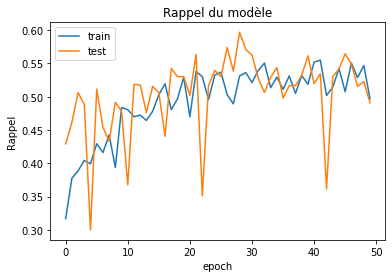

In [ ]:
# summarize history for accuracy
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Rappel du modèle')
plt.ylabel('Rappel')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

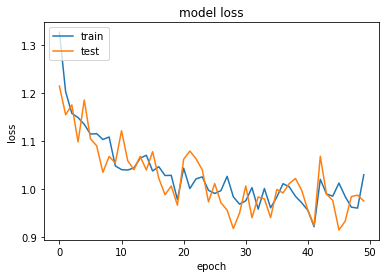

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Réseau ResNet50

In [ ]:
from keras import layers, models
from tensorflow.keras.applications import ResNet50V2

conv_base = ResNet50V2(weights="imagenet", include_top=False, input_shape=(150, 300, 3))

# On gèle les poids des couches d'instanciation du modèle
conv_base.trainable = False

model_preTrained2 = models.Sequential()

# Instanciation
model_preTrained2.add(conv_base)

# Classifieur
model_preTrained2.add(layers.Flatten())
model_preTrained2.add(layers.Dropout(0.5))
model_preTrained2.add(layers.Dense(32, activation='relu'))
model_preTrained2.add(layers.Dense(5, activation='softmax'))

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model_preTrained2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 10, 2048)       23564800  
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dropout (Dropout)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 32)                3276832   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 26,841,797
Trainable params: 3,276,997
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers, metrics

model_preTrained2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[recall_m, precision_m, f1_m])

In [ ]:
history = model_preTrained2.fit_generator(train_generator, validation_data=val_generator,
                                   steps_per_epoch=50, epochs=50, validation_steps=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
50/50 [==============================] - 228s 4s/step - loss: 1.1851 - recall_m: 0.3837 - precision_m: 0.7063 - f1_m: 0.4933 - val_loss: 1.1689 - val_recall_m: 0.4677 - val_precision_m: 0.6893 - val_f1_m: 0.5553
Epoch 2/50
50/50 [==============================] - 199s 4s/step - loss: 1.1202 - recall_m: 0.4112 - precision_m: 0.7346 - f1_m: 0.5242 - val_loss: 1.1621 - val_recall_m: 0.4583 - val_precision_m: 0.6757 - val_f1_m: 0.5438
Epoch 3/50
50/50 [==============================] - 187s 4s/step - loss: 1.1688 - recall_m: 0.4112 - precision_m: 0.7320 - f1_m: 0.5220 - val_loss: 1.1441 - val_recall_m: 0.4563 - val_precision_m: 0.6983 - val_f1_m: 0.5509
Epoch 4/50
50/50 [==============================] - 167s 3s/step - loss: 1.1340 - recall_m: 0.4169 - precision_m: 0.7438 - f1_m: 0.5295 - val_loss: 1.1204 - val_recall_m: 0.3823 - val_precision_m: 0.7915 - val_f1_m: 0.5112
Epoch 5/50
50/50 [==============================] - 146s 3s/step - loss: 1.1450 - recall_m: 0.3969 - precisi

In [ ]:
model_preTrained2.save('model_preTrained2.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


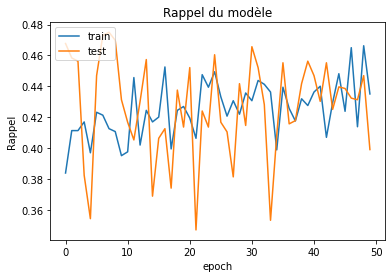

In [ ]:
import matplotlib.pyplot as plt 

# summarize history for accuracy
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Rappel du modèle')
plt.ylabel('Rappel')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

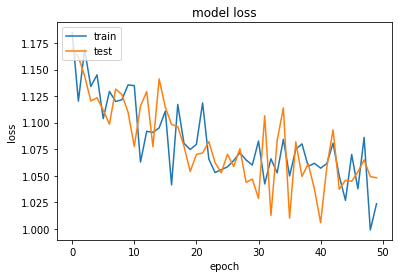

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Comparaison des modèles

Afin de terminer l'étude, il est nécessaire de comparer correctement les différents modèles mis en places afin de déterminer lequel a donné les meilleures performances.

In [4]:
# Chargement des modèles
from keras.models import load_model

model_dir = "/content/drive/MyDrive/Projets/Projet_CNN_countries/Modèles/"
dic_custom_metrics = {"recall_m": recall_m, "precision_m": precision_m, "f1_m": f1_m}

model_base = load_model(model_dir+'model_base.h5', custom_objects=dic_custom_metrics)
model_dataAug = load_model(model_dir+'model_dataAug.h5', custom_objects=dic_custom_metrics)
model_preTrained = load_model(model_dir+'model_preTrained.h5', custom_objects=dic_custom_metrics)
model_preTrained2 = load_model(model_dir+'model_preTrained2.h5', custom_objects=dic_custom_metrics)

In [9]:
scores_base = model_base.evaluate_generator(val_generator, 20)
scores_dataAug = model_dataAug.evaluate_generator(val_generator, 20)
scores_preTrained = model_preTrained.evaluate_generator(val_generator, 20)
scores_preTrained2 = model_preTrained2.evaluate_generator(val_generator, 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  aft

In [10]:
print(f"Modèle base:\n\tLoss: {round(scores_base[0], 3)}, \tRecall: {round(scores_base[1], 3)}, \tF1-score: {round(scores_base[3], 3)}\n")
print(f"Modèle dataAug:\n\tLoss: {round(scores_dataAug[0], 3)}, \tRecall: {round(scores_dataAug[1], 3)}, \tF1-score: {round(scores_dataAug[3], 3)}\n")
print(f"Modèle preTrained:\n\tLoss: {round(scores_preTrained[0], 3)}, \tRecall: {round(scores_preTrained[1], 3)}, \tF1-score: {round(scores_preTrained[3], 3)}\n")
print(f"Modèle preTrained2:\n\tLoss: {round(scores_preTrained2[0], 3)}, \tRecall: {round(scores_preTrained2[1], 3)}, \tF1-score: {round(scores_preTrained2[3], 3)}\n")

Modèle base:
	Loss: 2.751, 	Recall: 0.605, 	F1-score: 0.61

Modèle dataAug:
	Loss: 1.011, 	Recall: 0.43, 	F1-score: 0.552

Modèle preTrained:
	Loss: 0.925, 	Recall: 0.552, 	F1-score: 0.632

Modèle preTrained2:
	Loss: 0.982, 	Recall: 0.449, 	F1-score: 0.571

